In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-85'

# SSRT by SSD

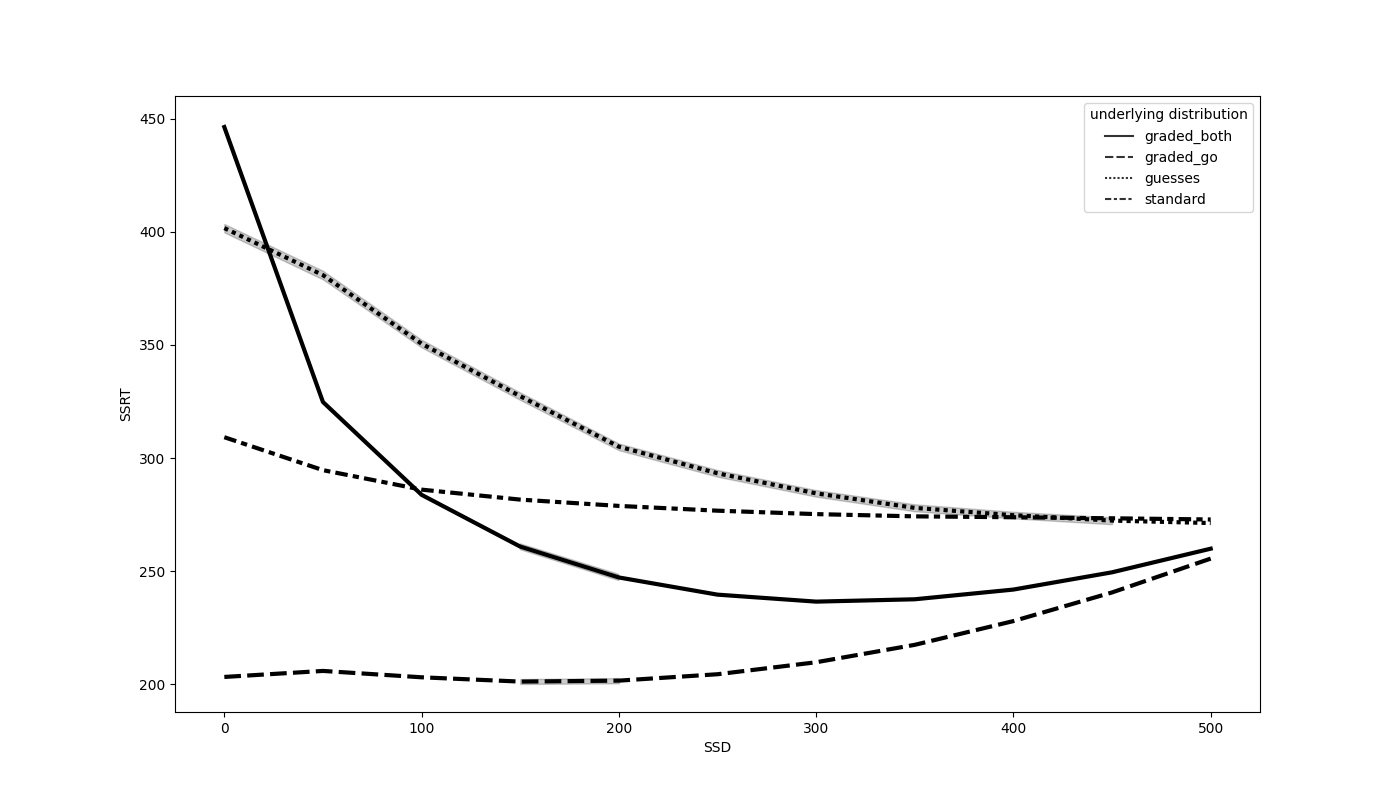

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

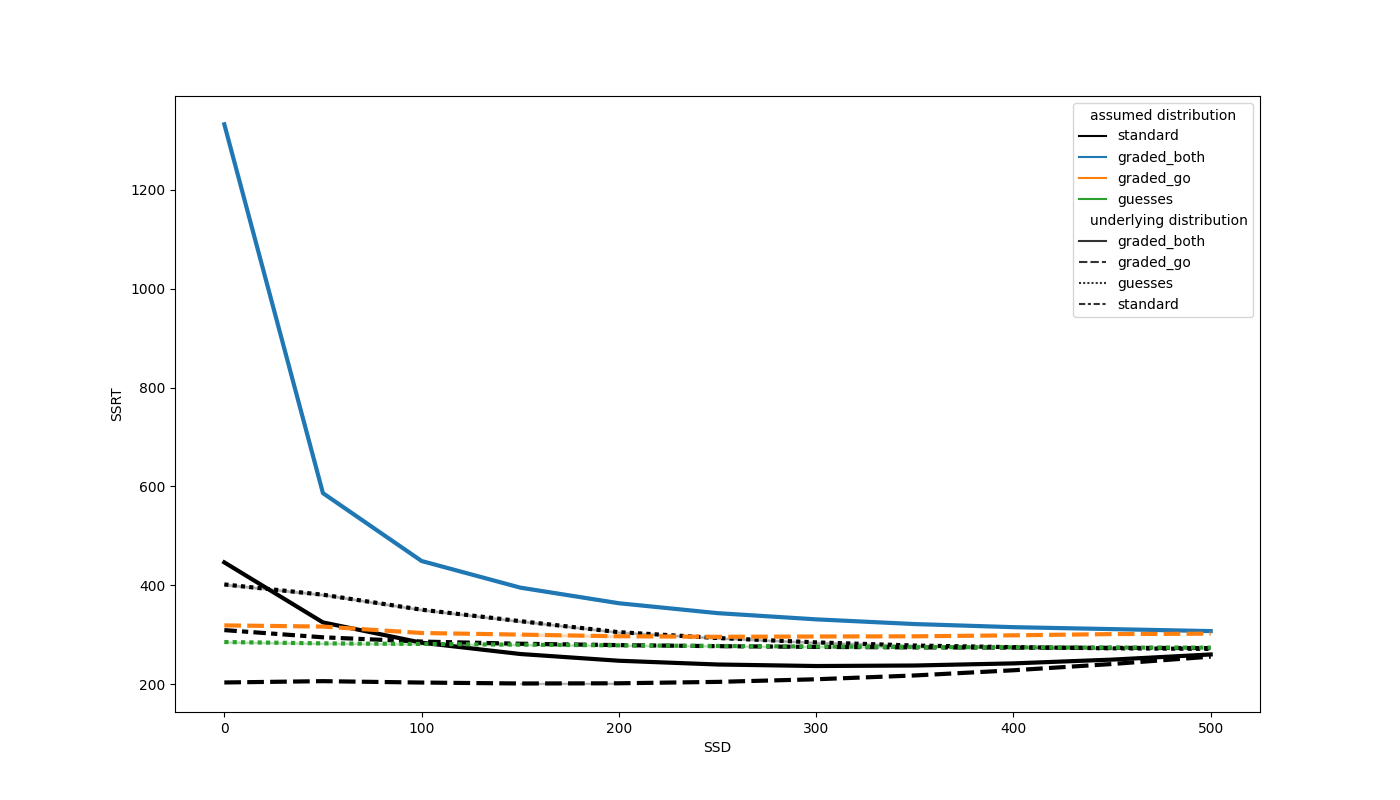

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

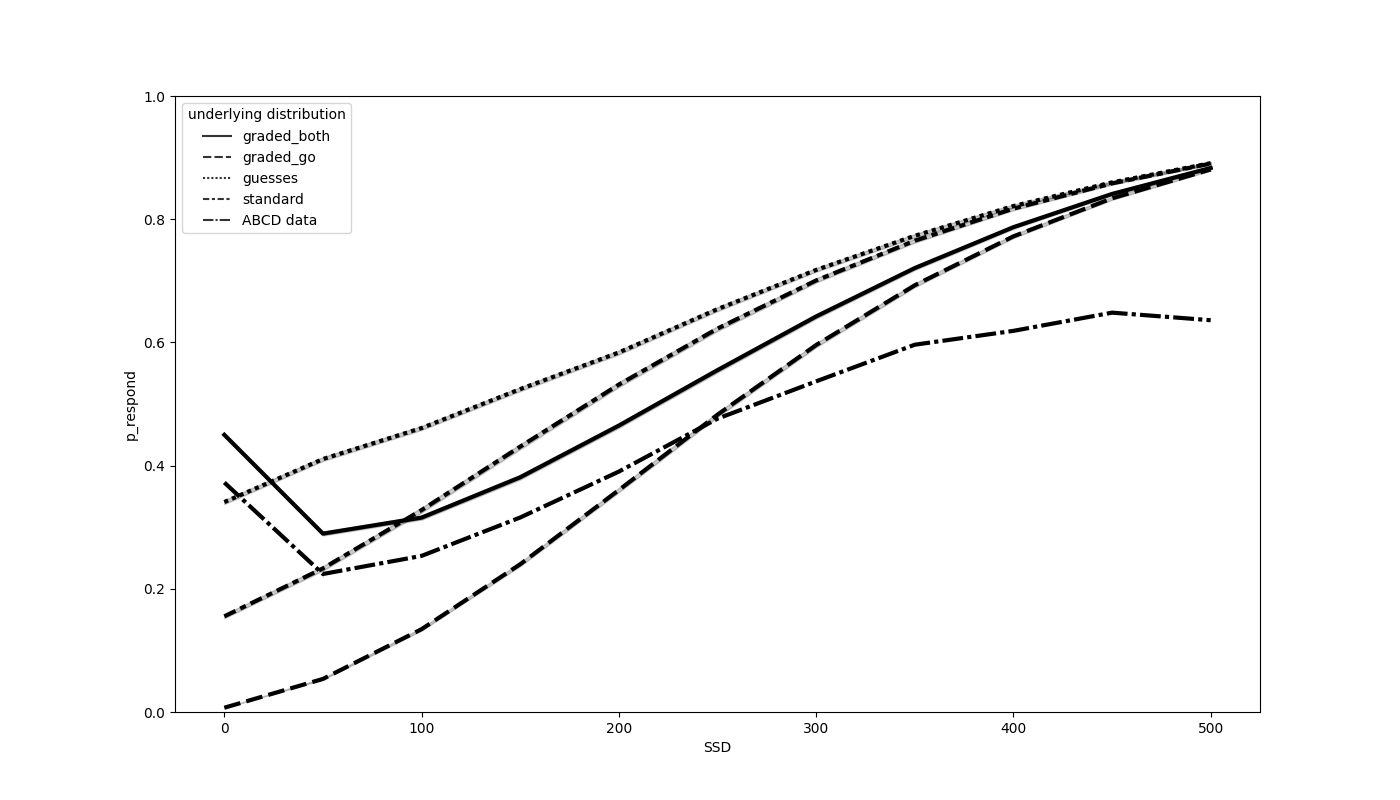

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)

    
# confirm that no kludge is required - check SSRTscale-0_RTscale-0 for use of kludge
tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1','gen-guesses_SSRT-tracking.2', 'gen-standard_SSRT-tracking.3']
for col in tracking_ssrts:
    assert sum(ssrt_df[col].isnull())==0

In [8]:
# sim_rt_info = pd.read_csv('simulated_data/sim_rt_meanStd.csv', index_col = 0)

In [9]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [10]:
mus_df.head()

,goRT,go,SSRT,stop
003RTV85,575.295505,0.190369,158.731993,0.919693
007W6H7B,453.614919,0.247761,222.859696,0.578504
00CY2MDM,617.052023,0.176351,269.084639,0.456445
00HEV6HB,546.564175,0.201384,158.648178,0.920402
00J52GPG,577.825255,0.189457,269.611172,0.455350


In [11]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [12]:
monster_df.shape

(8238, 28)

In [13]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

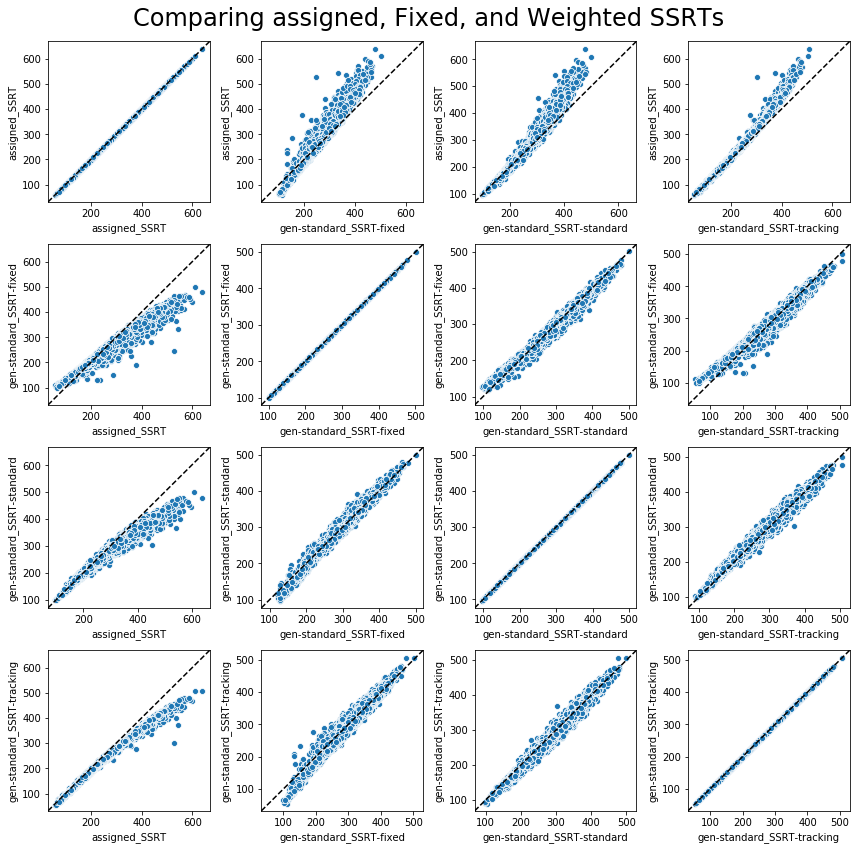

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [15]:
monster_df[columns].corr(method='spearman')

,assigned_SSRT,gen-standard_SSRT-fixed,gen-standard_SSRT-standard,gen-standard_SSRT-tracking
assigned_SSRT,1.000000,0.978762,0.987188,0.997752
gen-standard_SSRT-fixed,0.978762,1.000000,0.989290,0.983270
gen-standard_SSRT-standard,0.987188,0.989290,1.000000,0.988110
gen-standard_SSRT-tracking,0.997752,0.983270,0.988110,1.000000


# Comparing Fixed SSRTs

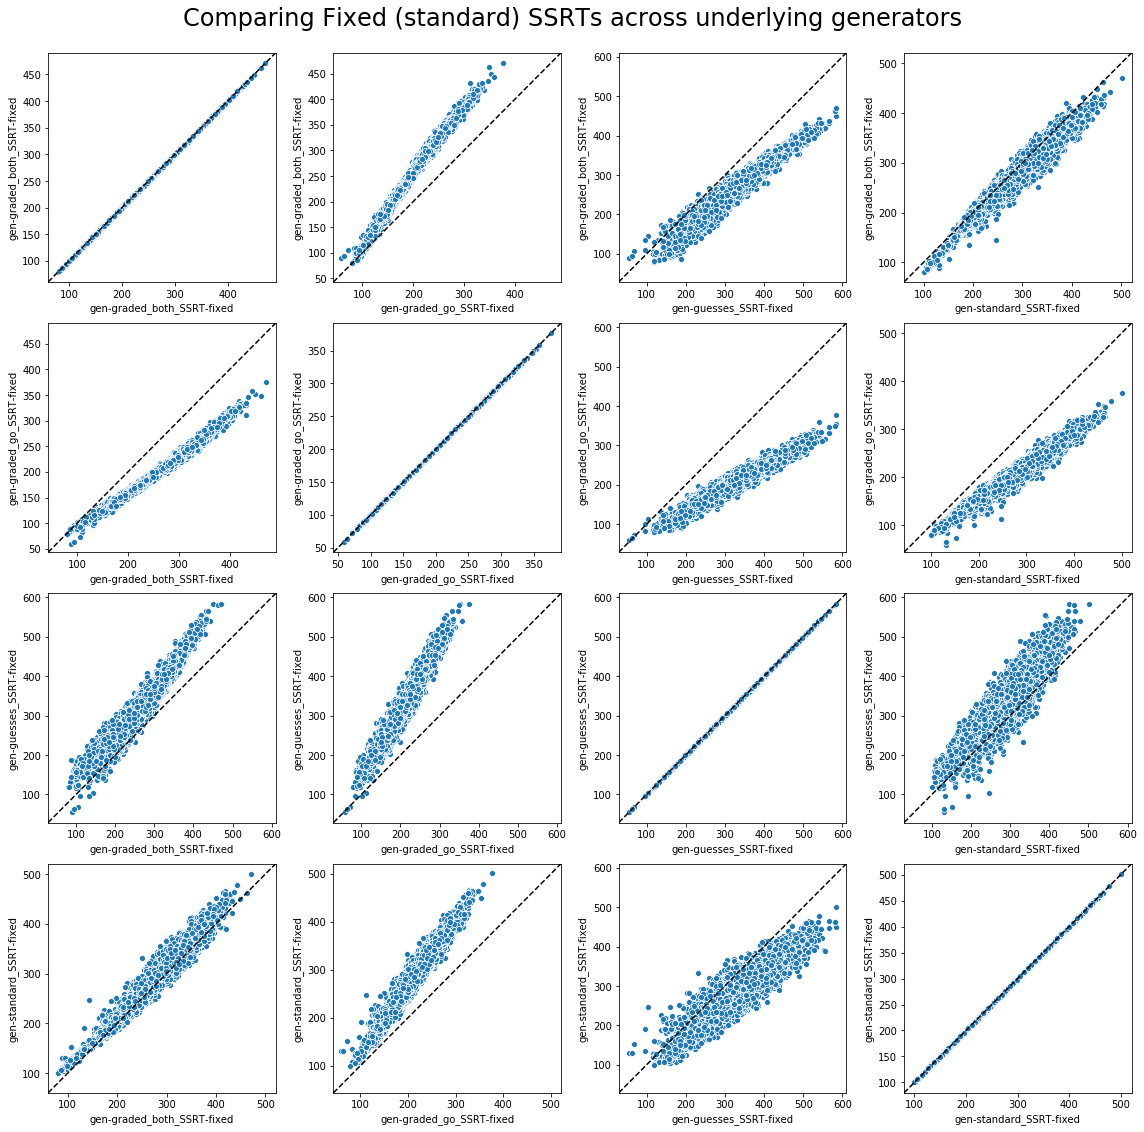

In [16]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [17]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed
gen-graded_both_SSRT-fixed,1.000000,0.995241,0.972835,0.973492
gen-graded_go_SSRT-fixed,0.995241,1.000000,0.969973,0.975533
gen-guesses_SSRT-fixed,0.972835,0.969973,1.000000,0.906890
gen-standard_SSRT-fixed,0.973492,0.975533,0.906890,1.000000


## (not rescaling the axes to get a closer look)

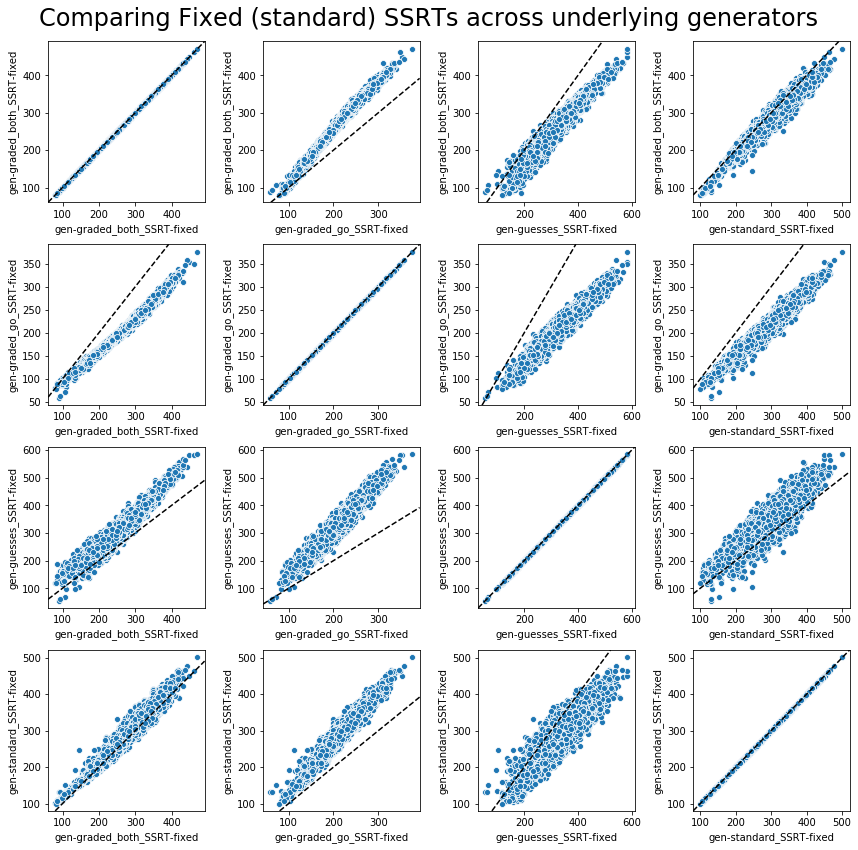

In [18]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

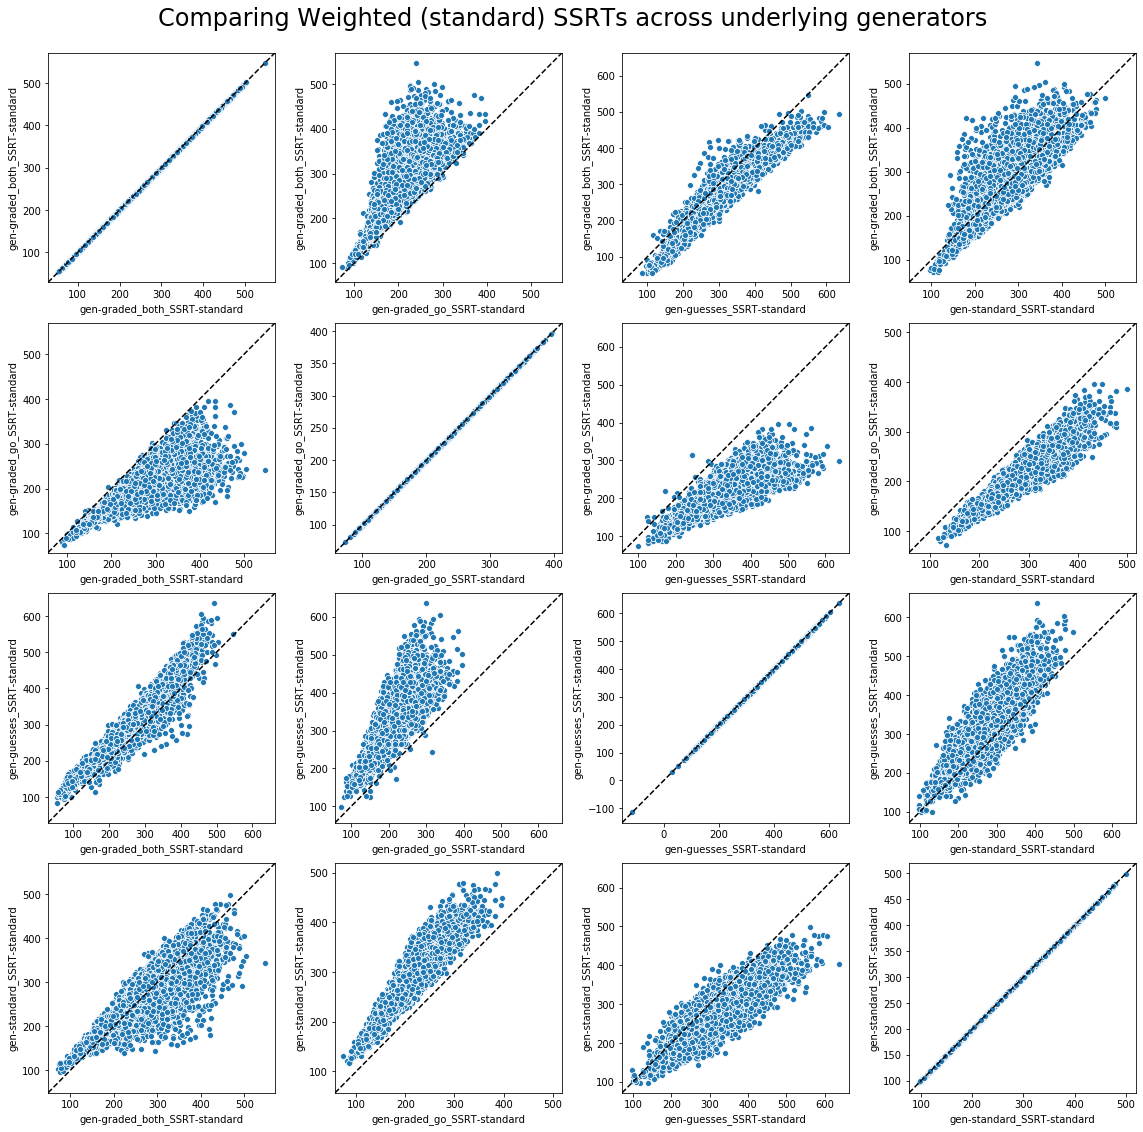

In [19]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [20]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard
gen-graded_both_SSRT-standard,1.000000,0.758175,0.954717,0.848070
gen-graded_go_SSRT-standard,0.758175,1.000000,0.800953,0.932132
gen-guesses_SSRT-standard,0.954717,0.800953,1.000000,0.883052
gen-standard_SSRT-standard,0.848070,0.932132,0.883052,1.000000


## not rescaling axis to get a closer look

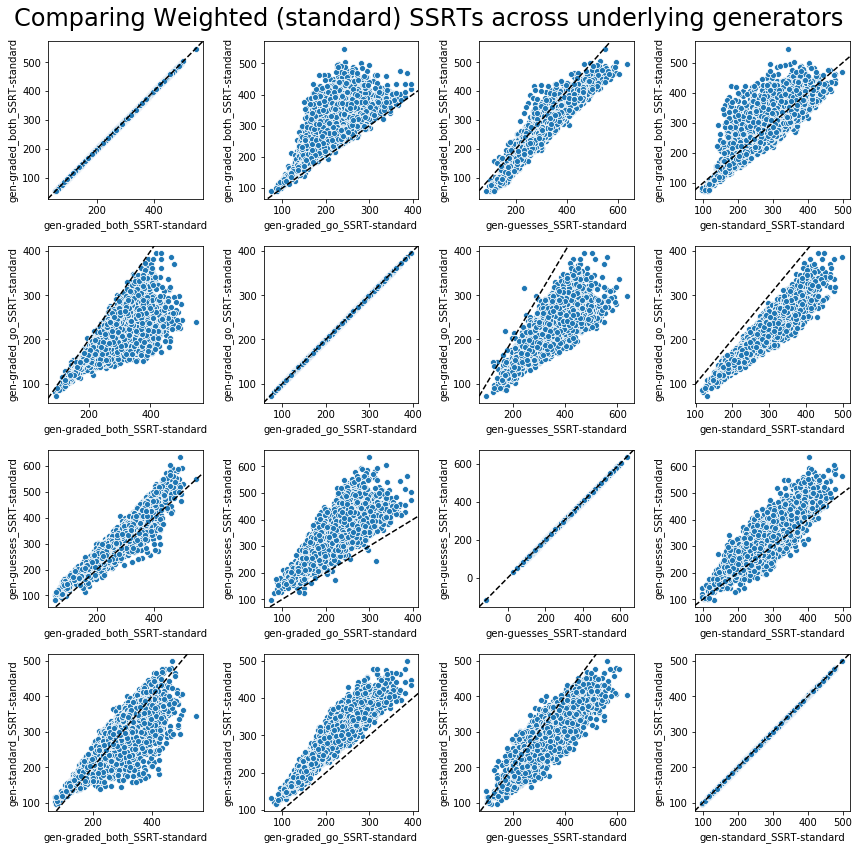

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

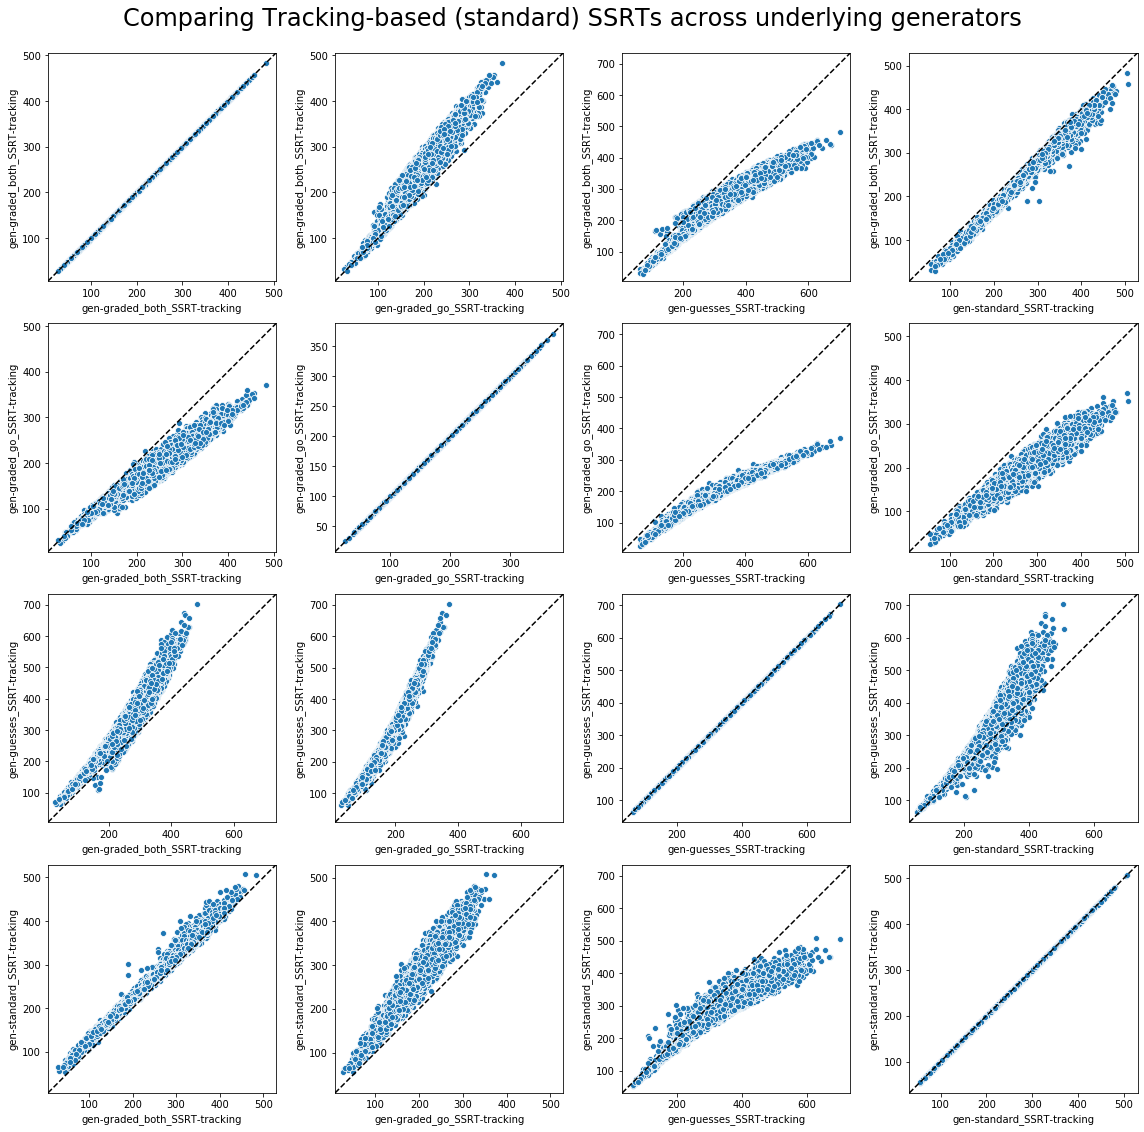

In [22]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [23]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
gen-graded_both_SSRT-tracking,1.000000,0.953057,0.957436,0.994810
gen-graded_go_SSRT-tracking,0.953057,1.000000,0.988424,0.948915
gen-guesses_SSRT-tracking,0.957436,0.988424,1.000000,0.950982
gen-standard_SSRT-tracking,0.994810,0.948915,0.950982,1.000000


## not rescaling axes

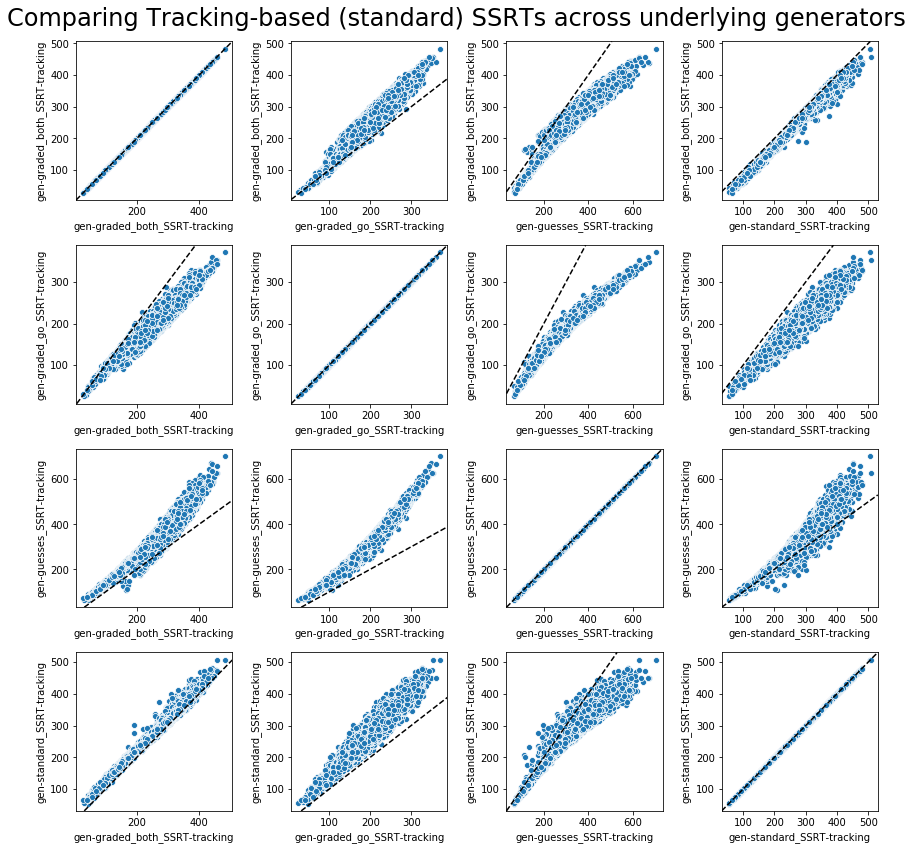

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [25]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

,assigned_SSRT,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
count,8238.000000,8184.000000,7486.000000,8238.000000,8020.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000
mean,299.798534,272.393825,217.886596,315.348547,284.816744,269.969410,209.209760,328.530104,281.246783,254.709538,200.969692,329.061483,276.683837
std,84.190078,69.687128,46.897596,77.669543,63.403157,60.423806,44.172314,74.615847,62.419787,74.327125,51.749329,97.754819,70.640325
min,60.351787,53.516667,73.100000,-115.000000,96.907407,80.000000,59.000000,55.000000,100.000000,28.558000,24.980000,63.678000,54.368000
25%,241.580304,226.845833,185.716667,263.911842,241.692572,230.000000,179.000000,276.000000,239.000000,203.002000,166.690500,259.695500,228.986000
50%,300.152577,274.213596,217.017767,315.158333,288.059483,274.000000,210.000000,330.000000,284.000000,259.198000,203.993000,329.246000,280.483000
75%,357.187032,318.950000,249.358333,365.441667,330.054167,313.000000,240.000000,380.000000,325.000000,309.094000,237.491500,396.387500,326.780000
max,639.169021,547.200000,396.477273,636.000000,499.650000,471.000000,376.000000,584.000000,501.000000,483.066000,370.988000,702.830000,507.088000


In [26]:
ssrt_df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard.1,gen-guesses_SSRT-standard.2,gen-standard_SSRT-standard.3,gen-graded_both_SSRT-guesses,gen-graded_go_SSRT-guesses.1,gen-guesses_SSRT-guesses.2,gen-standard_SSRT-guesses.3,gen-graded_both_SSRT-graded_go,gen-graded_go_SSRT-graded_go.1,...,gen-guesses_SSRT-graded_both.2,gen-standard_SSRT-graded_both.3,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed.1,gen-guesses_SSRT-fixed.2,gen-standard_SSRT-fixed.3,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking.1,gen-guesses_SSRT-tracking.2,gen-standard_SSRT-tracking.3
gen-graded_both_SSRT-standard,1.000000,0.758175,0.954717,0.848070,0.826337,0.251422,0.816975,0.502822,0.810437,0.722613,...,0.849366,0.765759,0.832775,0.830987,0.802776,0.823524,0.797558,0.831956,0.828053,0.794088
gen-graded_go_SSRT-standard.1,0.758175,1.000000,0.800953,0.932132,0.846303,0.773575,0.937325,0.804860,0.401039,0.816833,...,0.458268,0.594138,0.955442,0.960172,0.893298,0.967107,0.942722,0.963802,0.961764,0.940714
gen-guesses_SSRT-standard.2,0.954717,0.800953,1.000000,0.883052,0.775309,0.283341,0.856616,0.522471,0.699744,0.724781,...,0.801996,0.735178,0.916206,0.915362,0.912178,0.883527,0.840504,0.909605,0.903123,0.831826
gen-standard_SSRT-standard.3,0.848070,0.932132,0.883052,1.000000,0.930123,0.627338,0.992345,0.841924,0.580239,0.887465,...,0.671396,0.820223,0.945407,0.948271,0.859374,0.989290,0.987040,0.961287,0.964597,0.988110
gen-graded_both_SSRT-guesses,0.826337,0.846303,0.775309,0.930123,1.000000,0.639253,0.933497,0.860094,0.630733,0.849274,...,0.671354,0.827741,0.823594,0.825891,0.708097,0.899651,0.930426,0.849171,0.855097,0.935119
gen-graded_go_SSRT-guesses.1,0.251422,0.773575,0.283341,0.627338,0.639253,1.000000,0.676816,0.886080,-0.047668,0.605874,...,-0.022635,0.283727,0.602629,0.609421,0.499034,0.678448,0.707945,0.628577,0.633297,0.713638
gen-guesses_SSRT-guesses.2,0.816975,0.937325,0.856616,0.992345,0.933497,0.676816,1.000000,0.873118,0.548424,0.892502,...,0.651186,0.807649,0.935415,0.938076,0.848087,0.984428,0.990362,0.955340,0.956303,0.994014
gen-standard_SSRT-guesses.3,0.502822,0.804860,0.522471,0.841924,0.860094,0.886080,0.873118,1.000000,0.283084,0.789833,...,0.345428,0.665755,0.728229,0.733374,0.587018,0.837438,0.890170,0.763953,0.773457,0.896147
gen-graded_both_SSRT-graded_go,0.810437,0.401039,0.699744,0.580239,0.630733,-0.047668,0.548424,0.283084,1.000000,0.643863,...,0.937355,0.808247,0.476927,0.477734,0.418884,0.512613,0.523479,0.488475,0.494005,0.525069
gen-graded_go_SSRT-graded_go.1,0.722613,0.816833,0.724781,0.887465,0.849274,0.605874,0.892502,0.789833,0.643863,1.000000,...,0.689827,0.852955,0.793452,0.799378,0.677235,0.869525,0.892090,0.817992,0.829406,0.894104


## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [27]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8020
gen-standard_SSRT-guesses 8020
gen-standard_SSRT-graded_go 8020
gen-standard_SSRT-graded_both 8020
gen-guesses_SSRT-standard 8238
gen-guesses_SSRT-guesses 8238
gen-guesses_SSRT-graded_go 8238
gen-guesses_SSRT-graded_both 8238
gen-graded_go_SSRT-standard 7486
gen-graded_go_SSRT-guesses 7486
gen-graded_go_SSRT-graded_go 7486
gen-graded_go_SSRT-graded_both 7486
gen-graded_both_SSRT-standard 8184
gen-graded_both_SSRT-guesses 8184
gen-graded_both_SSRT-graded_go 8184
gen-graded_both_SSRT-graded_both 8184


# Plot graded Mu Go function

In [28]:
SSDs = np.arange(0,650, 5)

simulator = SimulateData()
mu_gos = [[i, simulator._log_grade_mu(1, i)] for i in SSDs]

/Users/henrymj/Documents/ABCD_simulations/scripts/utils.py:342: RuntimeWarning: divide by zero encountered in log
  return self._at_least_0((np.log(SSD/max_SSD)/4+1) * mu_go)


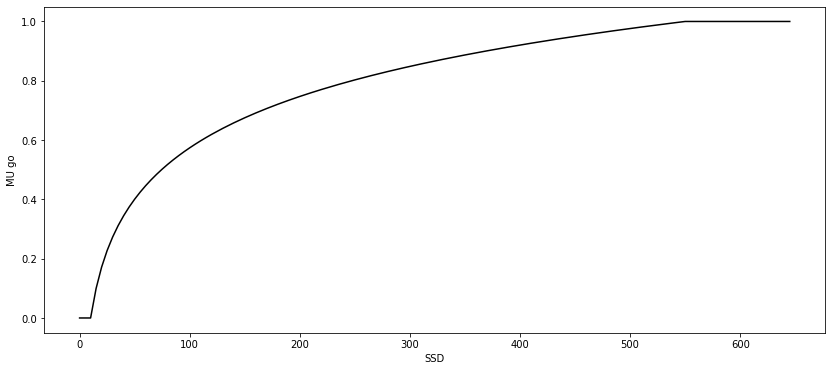

In [29]:
fig,ax = plt.subplots(1,1, figsize=(14, 6))

_ = sns.lineplot(x='SSD', y='MU go', color='k', data=pd.DataFrame(mu_gos, columns=['SSD', 'MU go']))
plt.savefig('figures/graded_mu_go_function.png')